In [5]:
#Add google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
#Add link to shared cross section library
#shared library was added as a shortcut to My Drive from the web interface
%env OPENMC_CROSS_SECTIONS = /gdrive/My Drive/data/endfb71_hdf5/cross_sections.xml

env: OPENMC_CROSS_SECTIONS=/gdrive/My Drive/data/endfb71_hdf5/cross_sections.xml


In [7]:
#Download miniconda and install
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-12-10 19:10:31--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   121MB/s    in 0.7s    

2020-12-10 19:10:32 (121 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ done

# All requested packages already installed.

installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories

In [8]:
# Install OpenMC
!conda config --add channels conda-forge
!conda install openmc -y

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openmc


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    cached-property-1.5.1      |             py_0          10 KB  conda-forge


In [9]:
import openmc

In [10]:
%matplotlib inline

In [ ]:
#I will building a mini vver pin-cell. 

This week tasks

In [ ]:
""" 
 
Use the openmc.model.pin function (https://docs.openmc.org/en/latest/pythonapi/generated/openmc.model.pin.html?highlight=openmc.model#openmc-model-pin)
Use the openmc.model.hex_prism or rect_prism functions when applicable
Use the borated water function (even if you need to set boron to 0ppm, this function will automatically lookup water properties for the temperature you give it)
Clean you your models of pins and assemblies (or small cores), and identify places to simplify the input
 
And here is a list of simpler functions that we can start working  on:
 
Add Gd2O3 calculations to the uranium enrichment function (we can also add Erbium, Dysprosium , …)
Add models for IFBA, WABA, …
Add pre-defined structural materials
Create/use the lattice acceleration method for non-TRISO geometries (TRIGA and RBMK)
Use CMFD for non Cartesian geometries
Function to create circular lattices like RBMK, CANDU
Function to create a BWR box with thin/thick geometry
Function to position control rod height
Function to create tallies for breeding ratio, fissile inventory ratio
Functions for thermodynamic properties of other coolants (Sodium, He, Heavy water, …)
"""

' \n \nUse the openmc.model.pin function (https://docs.openmc.org/en/latest/pythonapi/generated/openmc.model.pin.html?highlight=openmc.model#openmc-model-pin)\nUse the openmc.model.hex_prism or rect_prism functions when applicable\nUse the borated water function (even if you need to set boron to 0ppm, this function will automatically lookup water properties for the temperature you give it)\nClean you your models of pins and assemblies (or small cores), and identify places to simplify the input\n \nAnd here is a list of simpler functions that we can start working  on:\n \nAdd Gd2O3 calculations to the uranium enrichment function (we can also add Erbium, Dysprosium , …)\nAdd models for IFBA, WABA, …\nAdd pre-defined structural materials\nCreate/use the lattice acceleration method for non-TRISO geometries (TRIGA and RBMK)\nUse CMFD for non Cartesian geometries\nFunction to create circular lattices like RBMK, CANDU\nFunction to create a BWR box with thin/thick geometry\nFunction to positio

VVER sheet

In [38]:
# defining materials for 4 types of pincells. 
#fuells
au13=openmc.Material(name='13au',material_id=1)
au13.add_element('U',1.0,enrichment=1.3)
au13.add_element('O',2.0)
au13.set_density('g/cc', 10.4)

au22=openmc.Material(name='13au',material_id=2)
au22.add_element('U',1.0,enrichment=2.2)
au22.add_element('O',2.0)
au22.set_density('g/cc', 10.4)

av5=openmc.Material(name='30av5u',material_id=3)
av5.add_element('U',1.0,enrichment=3.0)
av5.add_element('O',2.0)
av5.set_density('g/cc', 10.4)

awu=openmc.Material(name='39awu',material_id=4)
awu.add_element('U',1.0,enrichment=3.3)
awu.add_element('O',2.0)
awu.set_density('g/cc', 10.4)

go=openmc.Material(name='390go',material_id=5)
go.add_element('U',1.0,enrichment=4.0)
go.add_element('O',2.0)
go.set_density('g/cc', 10.4)

Gd2O3=openmc.Material(name='Gd2O3',material_id=6)
Gd2O3.add_element('Gd',2.0)#>>>? Gd153
Gd2O3.add_element('O',3.0)
Gd2O3.set_density('g/cm3',7.41)
#moderator
water = openmc.Material(name='water',material_id=7)
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')
#clad
zirconium = openmc.Material(name="zirconium",material_id=8)
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

niobium=openmc.Material(name='niobium',material_id=9)
niobium.add_element('Nb',1.0)
niobium.set_density('g/cm3',8.57)
#gap
helium=openmc.Material(name='Helium',material_id=10)
helium.add_element('He',1.0)
helium.set_density('g/cm3',0.178*10**(-3))
# for thermal data
vapor_mat = openmc.Material(material_id=11)
vapor_mat.add_nuclide('Na23',1.0)
vapor_mat.set_density('g/cm3',0.10)

#reflector
reflector_mat = openmc.Material(material_id=12)
reflector_mat.add_nuclide('Be9',1.0)
reflector_mat.add_nuclide('O16',1.0)
reflector_mat.set_density('g/cm3',2.9)

/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=4.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=5.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=6.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=7.
  warn(m

In [39]:
#preparing mixtures
alloy=openmc.Material.mix_materials([niobium, zirconium],[0.01, 0.99],'wo')
fuel_awu = openmc.Material.mix_materials([Gd2O3, awu], [0.05, 0.95], 'wo')
fuel_go = openmc.Material.mix_materials([Gd2O3, go], [0.05, 0.95], 'wo')

In [40]:
# Instantiate a Materials collection
materials_file = openmc.Materials([au13, au22, av5, fuel_awu, fuel_go, water, alloy, vapor_mat, reflector_mat])

# Export to "materials.xml"
materials_file.export_to_xml()

In [55]:
# Designing General Geometry

# boudries and outer universe
#outer_water=openmc.Cell(fill=water)
all_water_out=openmc.Cell(cell_id=200,fill=water)

# top & bottom of the assembly 
assembly_z0 = openmc.ZPlane(surface_id=300,z0=-75)
assembly_z1 = openmc.ZPlane(surface_id=301, z0=75)
assembly = openmc.model.hexagonal_prism(edge_length=18, orientation='y')
# top & bottom of the reflector
reflector_z0 = openmc.ZPlane(surface_id=303,z0=-95, boundary_type='vacuum')
reflector_z1 = openmc.ZPlane(surface_id=304,z0=95, boundary_type='vacuum')

# reflector hexagon
reflector = openmc.model.hexagonal_prism(edge_length=18, orientation='y',
    boundary_type='vacuum')
# others
fuel_or = openmc.ZCylinder(surface_id=305,r=0.3765)
clad_ir = openmc.ZCylinder(surface_id=306,r=0.4)# ~0.02 cm gap >> supposedly helium
clad_or = openmc.ZCylinder(surface_id=307,r=0.465)
mod_region=openmc.ZCylinder(r=0.55)
# mod_hexagonal= openmc.model.hexagonal_prism(edge_length=0.55, orientation='y',boundary_type='vacuum')#>>>?
#mod=openmc.ZCylinder(r=0.55)
fuel_region = -fuel_or & -assembly_z1 & +assembly_z0
gap_region = +fuel_or & -clad_ir & -assembly_z1 & +assembly_z0
clad_region = +clad_ir & -clad_or & -assembly_z1 & +assembly_z0
moderator_region= -mod_region & +clad_or & -assembly_z1 & +assembly_z0

gap_cell=openmc.Cell(cell_id=400, region=gap_region)
cladcell=openmc.Cell(cell_id=401,fill=alloy, region=clad_region)
water_cell=openmc.Cell(cell_id=402,fill=water, region=moderator_region)


assembly_cell = openmc.Cell()
reflect_cell = openmc.Cell()
top_reflect_cell = openmc.Cell()
bot_reflect_cell = openmc.Cell()


/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=200.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=300.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=301.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=303.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=304.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=305.
  warn(msg, IDWarning)
/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=306.
  wa

In [56]:

#regions

assembly_cell.region = assembly & -assembly_z1 & +assembly_z0

reflect_cell.region = ~assembly & reflector \
& -assembly_z1 & +assembly_z0

top_reflect_cell.region = reflector & +assembly_z1 & -reflector_z1 \

bot_reflect_cell.region = reflector & -assembly_z0 & +reflector_z0 \
#pie fillings

reflect_cell.fill = reflector_mat
top_reflect_cell.fill = reflector_mat
bot_reflect_cell.fill = reflector_mat

#turn cell to universe to make it easier
all_water_out_u=openmc.Universe(cells=[all_water_out])
u_reflect = openmc.Universe(cells=(reflect_cell,top_reflect_cell,bot_reflect_cell))
u_root = openmc.Universe()


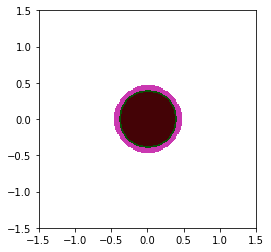

In [57]:
# centeral tube >> water
centeral_tube= openmc.Cell(fill=water,region=fuel_region)
centeral_tube_u=openmc.Universe(cells=[centeral_tube,gap_cell,cladcell])
geom=openmc.Geometry(centeral_tube_u)
geom.export_to_xml()
centeral_tube_u.plot(width=(3,3))

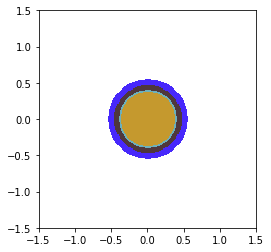

In [58]:
# geometry of 13 au
au13_fuel_cell=openmc.Cell(fill=au13, region=fuel_region)
au13_u=openmc.Universe(cells=(au13_fuel_cell, gap_cell, cladcell, water_cell))

geom=openmc.Geometry(au13_u)
geom.export_to_xml()


au13_u.plot(width=(3,3))

In [71]:
#######################
# Run Settings
######################

uniform_dist = openmc.stats.Box([-24,-24,-75],[24,24,75],only_fissionable=True)

settings = openmc.Settings()
settings.seed = 1
settings.batches = 200
settings.inactive = 100
settings.particles = 100
settings.source = openmc.source.Source(space=uniform_dist)
settings.export_to_xml()


In [72]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

CalledProcessError: ignored

In [59]:
#geometry of 22 au
au22_fuel_cell=openmc.Cell(fill=au22, region=fuel_region)
au22_u=openmc.Universe(cells=(au22_fuel_cell, gap_cell, cladcell, water_cell))

geom=openmc.Geometry(au22_u)
geom.export_to_xml()

In [60]:
#geometry av5
av5_fuel_cell=openmc.Cell(fill=av5, region=fuel_region)
av5_u=openmc.Universe(cells=(av5_fuel_cell, gap_cell, cladcell, water_cell))

geom=openmc.Geometry(av5_u)
geom.export_to_xml()

In [61]:
#geometry of awu
awu_fuel_cell=openmc.Cell(fill=fuel_awu, region=fuel_region)
awu_u=openmc.Universe(cells=(awu_fuel_cell, gap_cell, cladcell, water_cell))

geom=openmc.Geometry(awu_u)
geom.export_to_xml()

In [62]:
#geometry of go
go_fuel_cell=openmc.Cell(fill=fuel_go, region=fuel_region)
go_u=openmc.Universe(cells=(go_fuel_cell, gap_cell, cladcell, water_cell))

geom=openmc.Geometry(go_u)
geom.export_to_xml()

Reactor core:/

In [63]:
# we have 163 pincell, .... 
"""
 Number of assemblies
13au 48
22au 42 
30av5 37 
39awu 24 
390go 12
"""
lat=openmc.HexLattice(name='assembly')
lat.center = (0., 0.)
lat.pitch = (1.275,)###
lat.outer=all_water_out_u

#lat.outer = u_monolith
#lat.orientation='x'
# print(lat.show_indices(7,orientation='x')) # with 7 cycles we would have 169 pincell, but we know that 6 pincell are removed according to graphs.

                                    (0,24)      (0,25)      (0,26)      (0,27)      (0,28)      (0,29)      (0,30)

                              (0,23)      (1,20)      (1,21)      (1,22)      (1,23)      (1,24)      (1,25)      (0,31)

                        (0,22)      (1,19)      (2,16)      (2,17)      (2,18)      (2,19)      (2,20)      (1,26)      (0,32)

                  (0,21)      (1,18)      (2,15)      (3,12)      (3,13)      (3,14)      (3,15)      (2,21)      (1,27)      (0,33)

            (0,20)      (1,17)      (2,14)      (3,11)      (4, 8)      (4, 9)      (4,10)      (3,16)      (2,22)      (1,28)      (0,34)

      (0,19)      (1,16)      (2,13)      (3,10)      (4, 7)      (5, 4)      (5, 5)      (4,11)      (3,17)      (2,23)      (1,29)      (0,35)

(0,18)      (1,15)      (2,12)      (3, 9)      (4, 6)      (5, 3)      (6, 0)      (5, 0)      (4, 0)      (3, 0)      (2, 0)      (1, 0)      (0, 0)

      (0,17)      (1,14)      (2,11)      (3, 8)      (4, 5)  

In [66]:
#ring8=[centeral_tube_u]*48
#ring7=[awu_u, awu_u, go_u, centeral_tube_u, go_u, awu_u, awu_u]*6
ring7=[awu_u, awu_u, go_u,awu_u, go_u, awu_u, awu_u]*6

#ring7=[au22_u, au13_u, au22_u, av5_u, av5_u,au13_u, av5_u]*6
ring6= [au22_u, av5_u, au22_u,
        av5_u, au22_u, av5_u,
        au13_u,av5_u, au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u]
ring5= [au13_u, au13_u, au22_u, au13_u, au13_u]*6
ring4=[au22_u, av5_u, au13_u, av5_u]*6
ring3=[au13_u, au22_u, au13_u]*6
ring2=[au22_u, av5_u]*6
ring1=[au13_u]*6
ring0=[centeral_tube_u]
lat.universes = [ring7, ring6, ring5, ring4, ring3, ring2, ring1, ring0]
lat.oreintation='y'

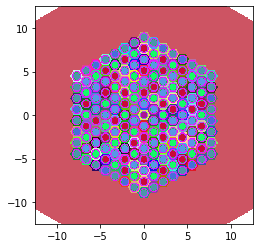

In [67]:
#outer_surface=openmc.model.hexagonal_prism(edge_length=18, orientation='y')
#main_assembly = openmc.Cell(fill=lat, region=outer_surface)
#main_u=openmc.Universe(cells=[main_assembly])

assembly_cell.fill = lat

u_root.add_cells([assembly_cell, reflect_cell, top_reflect_cell, bot_reflect_cell])
geom=openmc.Geometry(u_root)
geom.export_to_xml()

u_root.plot(origin=(0,0,0),width=(25,25),colors={water:'blue'},pixels=[400,400])
#u_root.plot(origin=(0,0,0),width=(25,25),color_by='material',pixels=[400,400])

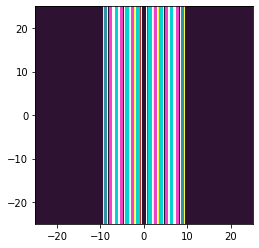

In [ ]:
u_root.plot(basis='yz',origin=(0,0,0),width=(50,50),color_by='material',pixels=[200,200])

In [68]:
#######################
# Run Settings
######################

uniform_dist = openmc.stats.Box([-24,-24,-75],[24,24,75],only_fissionable=True)

settings = openmc.Settings()
settings.seed = 1
settings.batches = 200
settings.inactive = 100
settings.particles = 100
settings.source = openmc.source.Source(space=uniform_dist)
settings.export_to_xml()


In [69]:

#openmc.run()
!cat materials.xml


<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="13au">
    <density units="g/cc" value="10.4" />
    <nuclide ao="0.00011766243358040823" name="U234" />
    <nuclide ao="0.013164083737078027" name="U235" />
    <nuclide ao="0.9866579560029052" name="U238" />
    <nuclide ao="6.0297826436488724e-05" name="U236" />
    <nuclide ao="1.999242" name="O16" />
    <nuclide ao="0.000758" name="O17" />
  </material>
  <material depletable="true" id="2" name="13au">
    <density units="g/cc" value="10.4" />
    <nuclide ao="0.0001990977790376745" name="U234" />
    <nuclide ao="0.02227507757033689" name="U235" />
    <nuclide ao="0.977423794096276" name="U238" />
    <nuclide ao="0.00010203055434936236" name="U236" />
    <nuclide ao="1.999242" name="O16" />
    <nuclide ao="0.000758" name="O17" />
  </material>
  <material depletable="true" id="3" name="30av5u">
    <density units="g/cc" value="10.4" />
    <nuclide ao="0.0002714687807807027" name="

In [ ]:
# for control rodes 
#materials for rodes
def insert_rode(pitch,rode_type)
  

In [70]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

CalledProcessError: ignored